In [42]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

#### 將各模型重要度>0.1的特徵聯集

In [43]:
sex='Female'
xgb_importance = pd.read_csv(f'../result/feature_importance/normalized/{sex}_xgb.csv')
xgb_importance = xgb_importance[xgb_importance['importance']>0.1]
svm_importance = pd.read_csv(f'../result/feature_importance/normalized/{sex}_svm.csv')
svm_importance = svm_importance[svm_importance['importance']>0.1]
xgb_importance = xgb_importance.rename(columns={"importance": "xgb_importance"})
svm_importance = svm_importance.rename(columns={"importance": "svm_importance"})
outer_1 = pd.merge(xgb_importance, svm_importance, on="feature", how="outer")

rf_importance = pd.read_csv(f'../result/feature_importance/normalized/{sex}_rf.csv')
rf_importance = rf_importance[rf_importance['importance']>0.1]
dt_importance = pd.read_csv(f'../result/feature_importance/normalized/{sex}_dt.csv')
dt_importance = dt_importance[dt_importance['importance']>0.1]
rf_importance = rf_importance.rename(columns={"importance": "rf_importance"})
dt_importance = dt_importance.rename(columns={"importance": "dt_importance"})
outer_2 = pd.merge(rf_importance, dt_importance, on="feature", how="outer")
outer = pd.merge(outer_1, outer_2, on="feature", how="outer")
outer.shape

(60, 5)

#### 使用Boruta取出重要度排名=1的特徵

In [44]:
control=pd.read_csv(f"../result/Control_{sex}.csv")
training=pd.read_csv(f"../result/Training_{sex}.csv")

print(control.shape)
print(training.shape)

(4588, 166)
(2099, 166)


In [45]:
features = pd.concat([control,training],ignore_index=True)
features = features[outer['feature']]

X = features
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=list(pd.concat([control_label,training_label],ignore_index=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Data columns (total 60 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   I_16                            6687 non-null   float64
 1   I_22                            6687 non-null   float64
 2   I_11                            6687 non-null   float64
 3   ORTHOPEDICS_ARTICULUS           6687 non-null   float64
 4   I_17                            6687 non-null   float64
 5   EYE_DIS                         6687 non-null   float64
 6   I_18                            6687 non-null   float64
 7   ARTICULUS_ACHE                  6687 non-null   float64
 8   MENSTRURATION_CURR              6687 non-null   float64
 9   I_33                            6687 non-null   float64
 10  HEART_BLOOD_TUBE                6687 non-null   float64
 11  I_15                            6687 non-null   float64
 12  I_24                            66

In [46]:
from collections import Counter

# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 6018
測試集樣本數量： 669
訓練集中各類別樣本數量：
Counter({0: 4124, 1: 1894})
測試集中各類別樣本數量：
Counter({0: 464, 1: 205})


In [47]:
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print('SMOTE train set sampling:')
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(random_state=42, kind='borderline-2').fit_resample(X_train, y_train)
print('BSMOTE train set sampling:')
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val,y_val)
print('Random sampling:')
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val,y_val)
print('SMOTE test set sampling:')
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val,y_val)
print('BSMOTE test set sampling:')
print(Counter(bsmote_test_Y))

SMOTE train set sampling:
Counter({1: 4124, 0: 4124})
BSMOTE train set sampling:
Counter({1: 4124, 0: 4124})
Random sampling:
Counter({0: 205, 1: 205})
SMOTE test set sampling:
Counter({0: 464, 1: 464})
BSMOTE test set sampling:
Counter({0: 464, 1: 464})


In [48]:
# Random forest
from sklearn import ensemble
from sklearn.metrics import accuracy_score

model = ensemble.RandomForestClassifier(random_state=42)
param_grid = {
    # Male
    # 'n_estimators': [100,150,200],
    # 'min_samples_split': [50,60,70],
    # 'min_samples_leaf': [50,60,70]

    # Female
    'n_estimators': [100,150,200],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [30,40,50]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(smote_train_X, smote_train_Y)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(smote_test_X)
print(accuracy_score(smote_test_Y, y_pred.round()))

y_pred_train = best_model.predict(smote_train_X)
print(accuracy_score(smote_train_Y, y_pred_train.round()))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}
Best Score: 0.7714836172519617
0.8038793103448276
0.8365664403491756


In [49]:
smote_train_X = pd.DataFrame(smote_train_X, columns=features.columns[:])
smote_train_Y = pd.DataFrame(smote_train_Y,columns=['Label'])
smote_train_X = smote_train_X.values
smote_train_Y = smote_train_Y.values.ravel()

In [50]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42,
                            min_samples_split=30, min_samples_leaf= 30, n_estimators=150)

boruta_selector = BorutaPy(rf)
boruta_selector.fit(smote_train_X,smote_train_Y)

feature_ranking = boruta_selector.ranking_
feature_names = features.columns[:]
ranking_boruta = pd.DataFrame({'feature': feature_names, 'ranking': feature_ranking})
print(ranking_boruta)
# ranking_boruta.to_csv(f"../result/Boruta/{sex}_boruta.csv",index=False)

                           feature  ranking
0                             I_16        1
1                             I_22        1
2                             I_11        1
3            ORTHOPEDICS_ARTICULUS        1
4                             I_17        1
5                          EYE_DIS        1
6                             I_18        1
7                   ARTICULUS_ACHE        1
8               MENSTRURATION_CURR        1
9                             I_33        1
10                HEART_BLOOD_TUBE        1
11                            I_15        1
12                            I_24        1
13                   XEROPHTHALMIA        1
14                       SPO_HABIT        1
15                            I_30        1
16                        DIABETES        1
17                        FLOATERS        1
18                            I_35        1
19                            I_26        1
20                     MC_DURATION        1
21                ALIMENTARY_CAN

#### 使用RFE觀察特徵剩餘10、15、20時的表現，取最佳特徵

In [51]:
features = pd.concat([control,training],ignore_index=True)
features = features[ranking_boruta[ranking_boruta['ranking']==1]['feature']]

#將ID排除
X = features
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=list(pd.concat([control_label,training_label],ignore_index=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   I_16                            6687 non-null   float64
 1   I_22                            6687 non-null   float64
 2   I_11                            6687 non-null   float64
 3   ORTHOPEDICS_ARTICULUS           6687 non-null   float64
 4   I_17                            6687 non-null   float64
 5   EYE_DIS                         6687 non-null   float64
 6   I_18                            6687 non-null   float64
 7   ARTICULUS_ACHE                  6687 non-null   float64
 8   MENSTRURATION_CURR              6687 non-null   float64
 9   I_33                            6687 non-null   float64
 10  HEART_BLOOD_TUBE                6687 non-null   float64
 11  I_15                            6687 non-null   float64
 12  I_24                            66

In [52]:
from collections import Counter

# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 6018
測試集樣本數量： 669
訓練集中各類別樣本數量：
Counter({0: 4124, 1: 1894})
測試集中各類別樣本數量：
Counter({0: 464, 1: 205})


In [53]:
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print('SMOTE train set sampling:')
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(random_state=42, kind='borderline-2').fit_resample(X_train, y_train)
print('BSMOTE train set sampling:')
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val,y_val)
print('Random sampling:')
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val,y_val)
print('SMOTE test set sampling:')
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val,y_val)
print('BSMOTE test set sampling:')
print(Counter(bsmote_test_Y))

X_train, y_train = smote_train_X, smote_train_Y
X_val, y_val = smote_test_X, smote_test_Y

SMOTE train set sampling:
Counter({1: 4124, 0: 4124})
BSMOTE train set sampling:
Counter({1: 4124, 0: 4124})
Random sampling:
Counter({0: 205, 1: 205})
SMOTE test set sampling:
Counter({0: 464, 1: 464})
BSMOTE test set sampling:
Counter({0: 464, 1: 464})


In [54]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import  recall_score, precision_score, accuracy_score, matthews_corrcoef
from sklearn import svm
from sklearn import ensemble

def set_parameters(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    return grid_search

#xgb
param_xgb = {
    # Male
    # 'learning_rate': [0.01,0.05, 0.1],
    # 'n_estimators': [10,50,100],
    # 'max_depth': [2,3, 4],
    # 'subsample': [0.5,0.6,0.7],
    # 'colsample_bytree': [0.2,0.3,0.4],
    # 'min_child_weight': [20,30,40]
    # Female
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100,200,300],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.4, 0.5, 0.6],
}
xgb_model = set_parameters(xgb.XGBClassifier(random_state=42), param_xgb)

# rf
param_rf = {
    # Male
    # 'n_estimators': [100,150,200,250],
    # 'min_samples_split': [50,60,70,80,90],
    # 'min_samples_leaf': [50,60,70,80,90]

    # Female
    'n_estimators': [100,150,200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [30,40,50],
    'max_features': [5,10,20]
}
rf_model = set_parameters(
    ensemble.RandomForestClassifier(random_state=42), param_rf
)

# SVM
param_svm = {
    # Male
    # 'kernel': ['rbf', 'poly', 'sigmoid']
    # Female
}
svm_model = set_parameters(svm.SVC(random_state=42), param_svm)

# dt
param_dt = {
    # Male
    # 'max_depth': [3,4,5,6,7,8,9],
    # 'max_features': [20,30,35,40]
    # Female
    'max_depth': [6,7,8,9,10],
    'max_features': [30,35,40]
}
dt_model = set_parameters(DecisionTreeClassifier(random_state=42), param_dt)

Select 10 features:
feature importances:
                 feature  importance
4                   I_18    0.166045
6     MENSTRURATION_CURR    0.158108
3                EYE_DIS    0.111706
1                   I_11    0.105232
2  ORTHOPEDICS_ARTICULUS    0.102085
8               DIABETES    0.090985
0                   I_16    0.076258
7              SPO_HABIT    0.065853
5         ARTICULUS_ACHE    0.063405
9      CARCINOMA_IN_SITU    0.060324


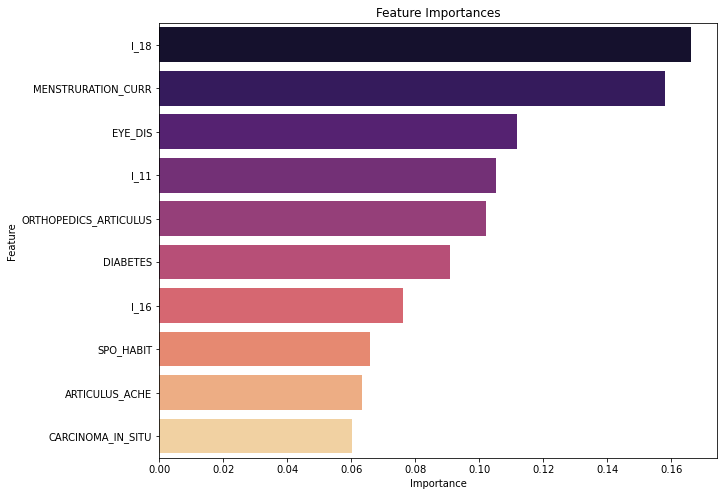

Testing model: XGBoost
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Best Score: 0.7710128820037856
Training Accuracy: 0.8034675072744908
Testing Accuracy: 0.7963362068965517
Testing model: Random Forest
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}
Best Score: 0.7479645698954371
Training Accuracy: 0.7881910766246363
Testing Accuracy: 0.7855603448275862
Testing model: Decision Tree
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 9, 'max_features': 30}
Best Score: 0.7471208629656174
Training Accuracy: 0.7886760426770126
Testing Accuracy: 0.7661637931034483
Testing model: SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {}
Best Score: 0.65

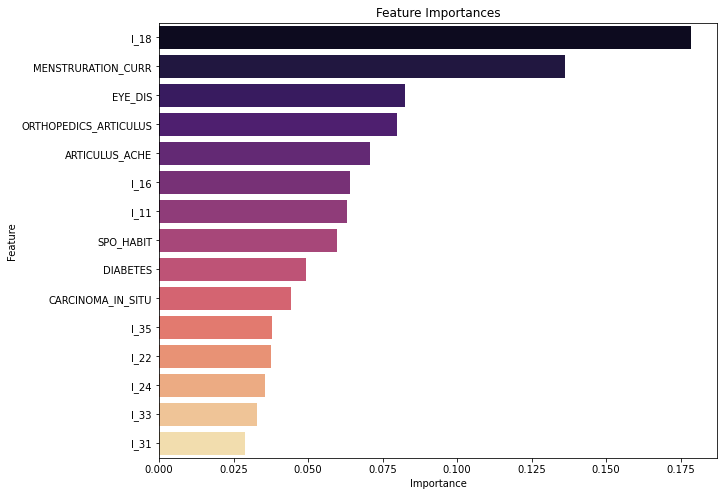

Testing model: XGBoost
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 0.7782861238216
Training Accuracy: 0.8114694471387003
Testing Accuracy: 0.7995689655172413
Testing model: Random Forest
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}
Best Score: 0.7579068305860301
Training Accuracy: 0.803831231813773
Testing Accuracy: 0.7920258620689655
Testing model: Decision Tree
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 9, 'max_features': 30}
Best Score: 0.7456613190730839
Training Accuracy: 0.7918283220174588
Testing Accuracy: 0.7575431034482759
Testing model: SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {}
Best Score: 0.6599

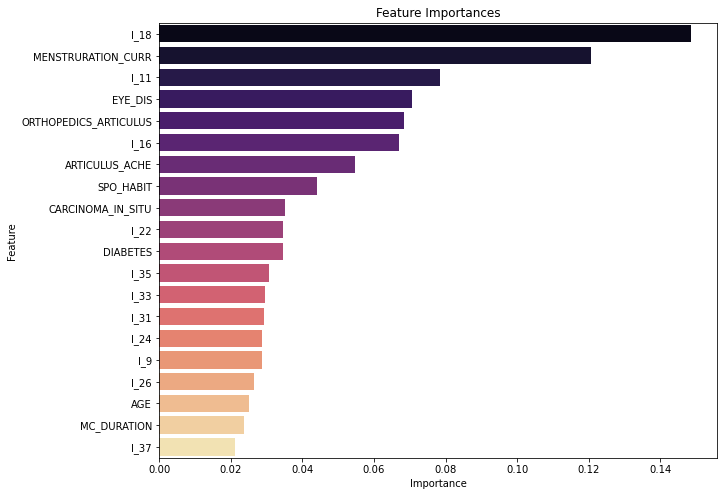

Testing model: XGBoost
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.6}
Best Score: 0.7879800797544885
Training Accuracy: 0.8320805043646945
Testing Accuracy: 0.8092672413793104
Testing model: Random Forest
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}
Best Score: 0.7683290148299246
Training Accuracy: 0.8210475266731329
Testing Accuracy: 0.8017241379310345
Testing model: Decision Tree
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 9, 'max_features': 30}
Best Score: 0.7342617196831873
Training Accuracy: 0.8027400581959263
Testing Accuracy: 0.7747844827586207
Testing model: SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {}
Best Score: 0.70

In [57]:
import seaborn as sns
models = {'XGBoost': xgb_model, 
         'Random Forest': rf_model, 
         'Decision Tree': dt_model,
         'SVM': svm_model}

results = {model_name: {'mcc': [],'accuracy':[], 'sensitivity': [], 'specificity': [], 'num_features': []} for model_name in models}

feature_count=20
for i in range(10,feature_count+1,5):
    print("Select",i,"features:")
    rfe = RFE(estimator=xgb.XGBClassifier(random_state=42), n_features_to_select=i)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_val_rfe = rfe.transform(X_val)
    selected_features = np.where(rfe.support_)[0]
    df_feature_importances = pd.DataFrame({
    'feature': features.columns[selected_features],
    'importance': rfe.estimator_.feature_importances_
    })
    df_feature_importances.sort_values('importance', ascending=False, inplace=True)

    print("feature importances:")
    print(pd.DataFrame(df_feature_importances))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=df_feature_importances, palette='magma')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    
    for test_name, test_model in models.items():
        print("Testing model:", test_name)
        grid_search = test_model
        grid_search.fit(X_train_rfe, y_train)
        print("Best Parameters:", grid_search.best_params_)
        print("Best Score:", grid_search.best_score_)
        best_model = grid_search.best_estimator_

        #train
        y_pred_train = best_model.predict(X_train_rfe)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        print("Training Accuracy:", accuracy_train)
    
        # test
        y_pred = best_model.predict(X_val_rfe)
        accuracy = accuracy_score(y_val, y_pred)
        print("Testing Accuracy:", accuracy)
        mcc = matthews_corrcoef(y_val, y_pred)
        sensitivity = recall_score(y_val, y_pred)
        specificity = precision_score(y_val, y_pred)
        
        results[test_name]['mcc'].append(mcc)
        results[test_name]['accuracy'].append(accuracy)
        results[test_name]['sensitivity'].append(sensitivity)
        results[test_name]['specificity'].append(specificity)
        results[test_name]['num_features'].append(i)

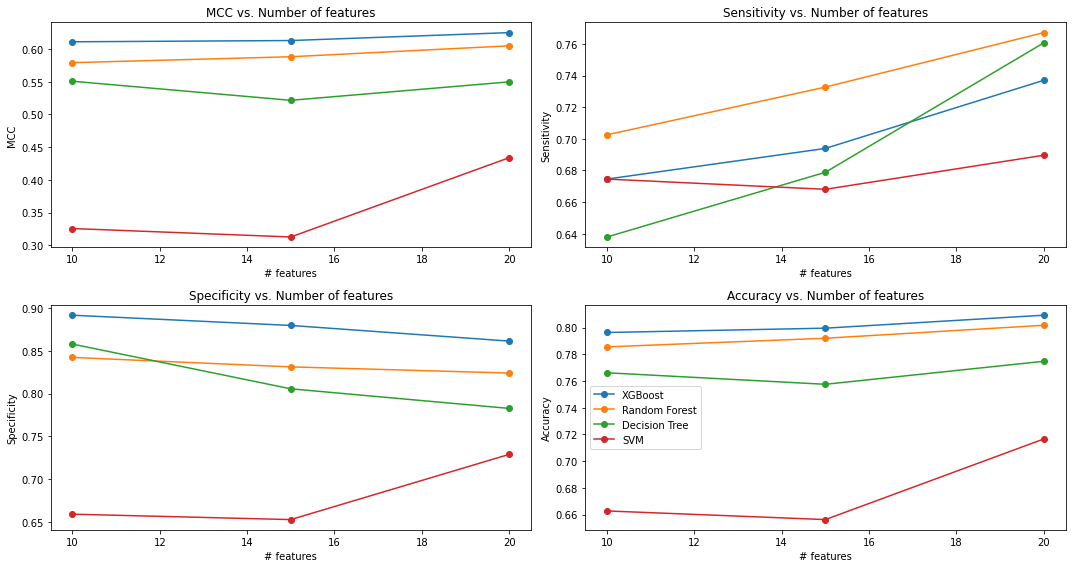

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

for model_name in models:
    # MCC
    axs[0, 0].plot(results[model_name]['num_features'], results[model_name]['mcc'], marker='o', label=model_name)
    axs[0, 0].set_xlabel('# features')
    axs[0, 0].set_ylabel('MCC')
    axs[0, 0].set_title('MCC vs. Number of features')
    
    # Sensitivity
    axs[0, 1].plot(results[model_name]['num_features'], results[model_name]['sensitivity'], marker='o', label=model_name)
    axs[0, 1].set_xlabel('# features')
    axs[0, 1].set_ylabel('Sensitivity')
    axs[0, 1].set_title('Sensitivity vs. Number of features')
    
    # Specificity
    axs[1, 0].plot(results[model_name]['num_features'], results[model_name]['specificity'], marker='o', label=model_name)
    axs[1, 0].set_xlabel('# features')
    axs[1, 0].set_ylabel('Specificity')
    axs[1, 0].set_title('Specificity vs. Number of features')

    # Accuracy
    axs[1, 1].plot(results[model_name]['num_features'], results[model_name]['accuracy'], marker='o', label=model_name)
    axs[1, 1].set_xlabel('# features')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_title('Accuracy vs. Number of features')

plt.legend()
plt.tight_layout()
plt.show()